In [19]:
import torch
import torch.nn as nn
import torchvisionz
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [20]:
import sys
import os

# Get the absolute path to the parent directory of 'src'
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from src.nets import MLP, LSTM
from train import train_model
from src.utils import create_binary_task

In [13]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Load and preprocess MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', 
                                         train=True,
                                         transform=transform,
                                         download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                        train=False, 
                                        transform=transform)

# Create shuffled data loaders
train_loader = DataLoader(dataset=train_dataset,
                         batch_size=128,
                         shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=128,
                        shuffle=False)

In [14]:
# Define hyperparameters
input_size = 28 * 28  # MNIST images are 28x28
hidden_size = 25
num_classes = 2  # Now binary classification
num_epochs = 20  # Fewer epochs per task
batch_size = 6000
learning_rate = 0.01
dropout_rate = 0.0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# Initialize models for binary classification
mlp_model = MLP(
    input_size=input_size, 
    hidden_size=hidden_size, 
    num_classes=num_classes,  # Now 2 instead of 10
    dropout_rate=dropout_rate
).to(device)

lstm_model = LSTM(
    input_size=28,
    hidden_size=hidden_size, 
    num_layers=1, 
    num_classes=num_classes,  # Now 2 instead of 10
    dropout_rate=dropout_rate
).to(device)

models = [
    ('mlp', mlp_model, nn.CrossEntropyLoss(), torch.optim.Adam(mlp_model.parameters(), lr=learning_rate)),
    ('lstm', lstm_model, nn.CrossEntropyLoss(), torch.optim.Adam(lstm_model.parameters(), lr=learning_rate))
]

In [16]:
# Define sequence of binary tasks
binary_tasks = [
    (i, j) for i in range(10) for j in range(i+1, 10)
]  # Generate all possible pairs of digits (45 pairs total)
binary_tasks = [binary_tasks[i] for i in torch.randperm(len(binary_tasks))]  # Randomly shuffle the order of tasks


In [17]:
# Training loop
train_logs = {}

for model_name, model, criterion, optimizer in models:
    print(f"Training {model_name}...")
    all_train_losses = []
    all_test_accuracies = []
    task_boundaries = []
    
    for task_idx, (class1, class2) in enumerate(binary_tasks):
        print(f"\nStarting Binary Task {task_idx + 1}: Class {class1} vs Class {class2}")
        
        # Create binary datasets
        binary_train = create_binary_task(train_dataset, (class1, class2))
        binary_test = create_binary_task(test_dataset, (class1, class2))
        
        # Train the model on this binary task
        train_losses, test_accuracies = train_model(
            model=model,
            train_data=binary_train,
            test_data=binary_test,
            num_epochs=num_epochs,
            device=device,
            criterion=criterion,
            optimizer=optimizer,
            batch_size=batch_size
        )
        
        all_train_losses.extend(train_losses)
        all_test_accuracies.extend(test_accuracies)
        task_boundaries.append(len(all_train_losses))
    
    train_logs[model_name] = {
        'all_train_losses': all_train_losses,
        'all_test_accuracies': all_test_accuracies,
        'task_boundaries': task_boundaries
    }

Training mlp...

Starting Binary Task 1: Class 0 vs Class 7
Epoch [1/20], Loss: 0.2492, Test Accuracy: 99.00%
Epoch [2/20], Loss: 0.0341, Test Accuracy: 99.30%
Epoch [3/20], Loss: 0.0205, Test Accuracy: 99.35%
Epoch [4/20], Loss: 0.0423, Test Accuracy: 99.35%
Epoch [5/20], Loss: 0.0069, Test Accuracy: 99.25%
Epoch [6/20], Loss: 0.0792, Test Accuracy: 99.35%
Epoch [7/20], Loss: 0.0314, Test Accuracy: 98.80%
Epoch [8/20], Loss: 0.0297, Test Accuracy: 99.15%
Epoch [9/20], Loss: 0.0005, Test Accuracy: 98.46%
Epoch [10/20], Loss: 0.0182, Test Accuracy: 99.30%
Epoch [11/20], Loss: 0.0004, Test Accuracy: 99.45%
Epoch [12/20], Loss: 0.0528, Test Accuracy: 99.50%
Epoch [13/20], Loss: 0.0003, Test Accuracy: 99.50%
Epoch [14/20], Loss: 0.0002, Test Accuracy: 99.30%
Epoch [15/20], Loss: 0.0086, Test Accuracy: 99.35%
Epoch [16/20], Loss: 0.0265, Test Accuracy: 99.60%
Epoch [17/20], Loss: 0.0026, Test Accuracy: 99.50%
Epoch [18/20], Loss: 0.0141, Test Accuracy: 99.50%
Epoch [19/20], Loss: 0.0019, Te

In [26]:
all_test_accuracies = train_log['all_test_accuracies']

len(all_test_accuracies)

900

Combined figure saved to: output/mnist_binary_mlp_combined.png


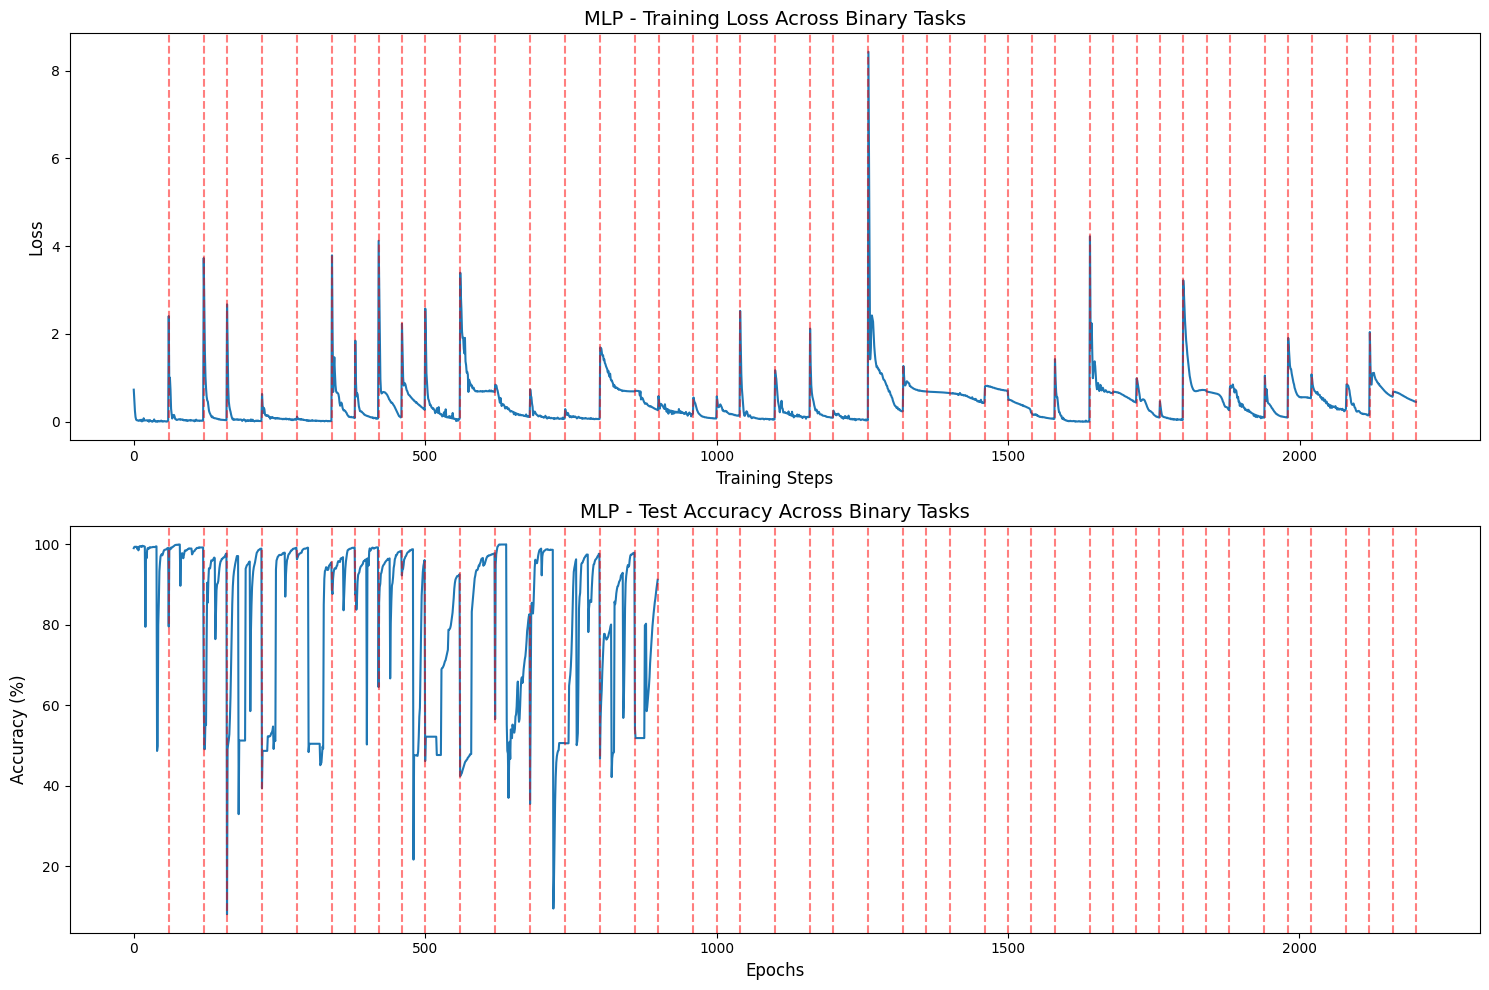

Loss figure saved to: output/mnist_binary_mlp_loss.png


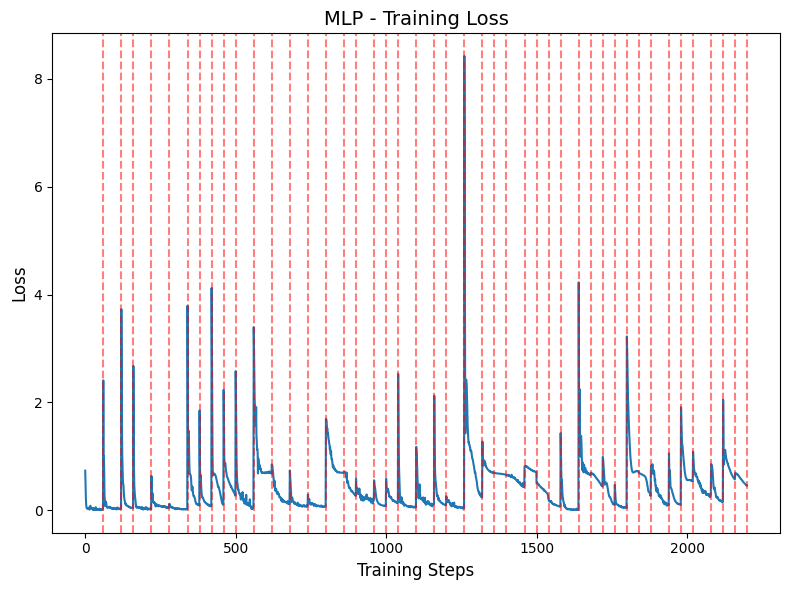

Accuracy figure saved to: output/mnist_binary_mlp_accuracy.png


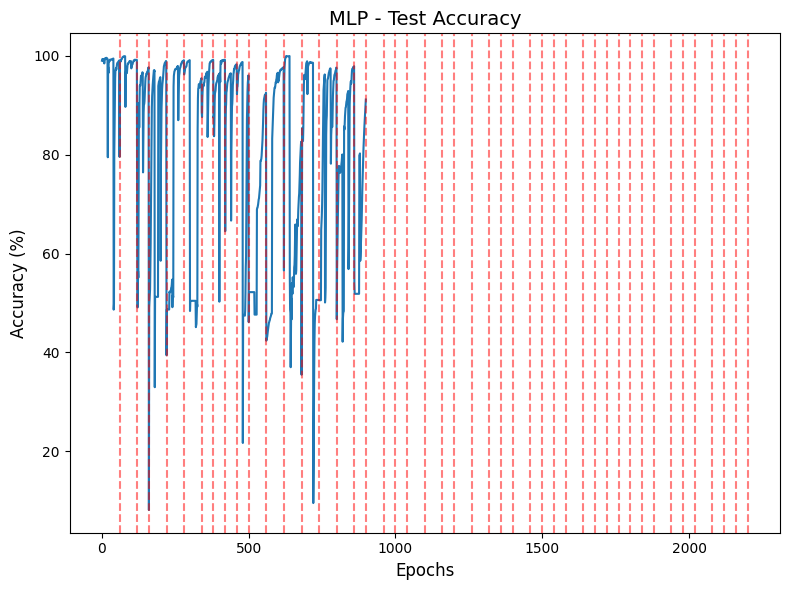

Combined figure saved to: output/mnist_binary_lstm_combined.png


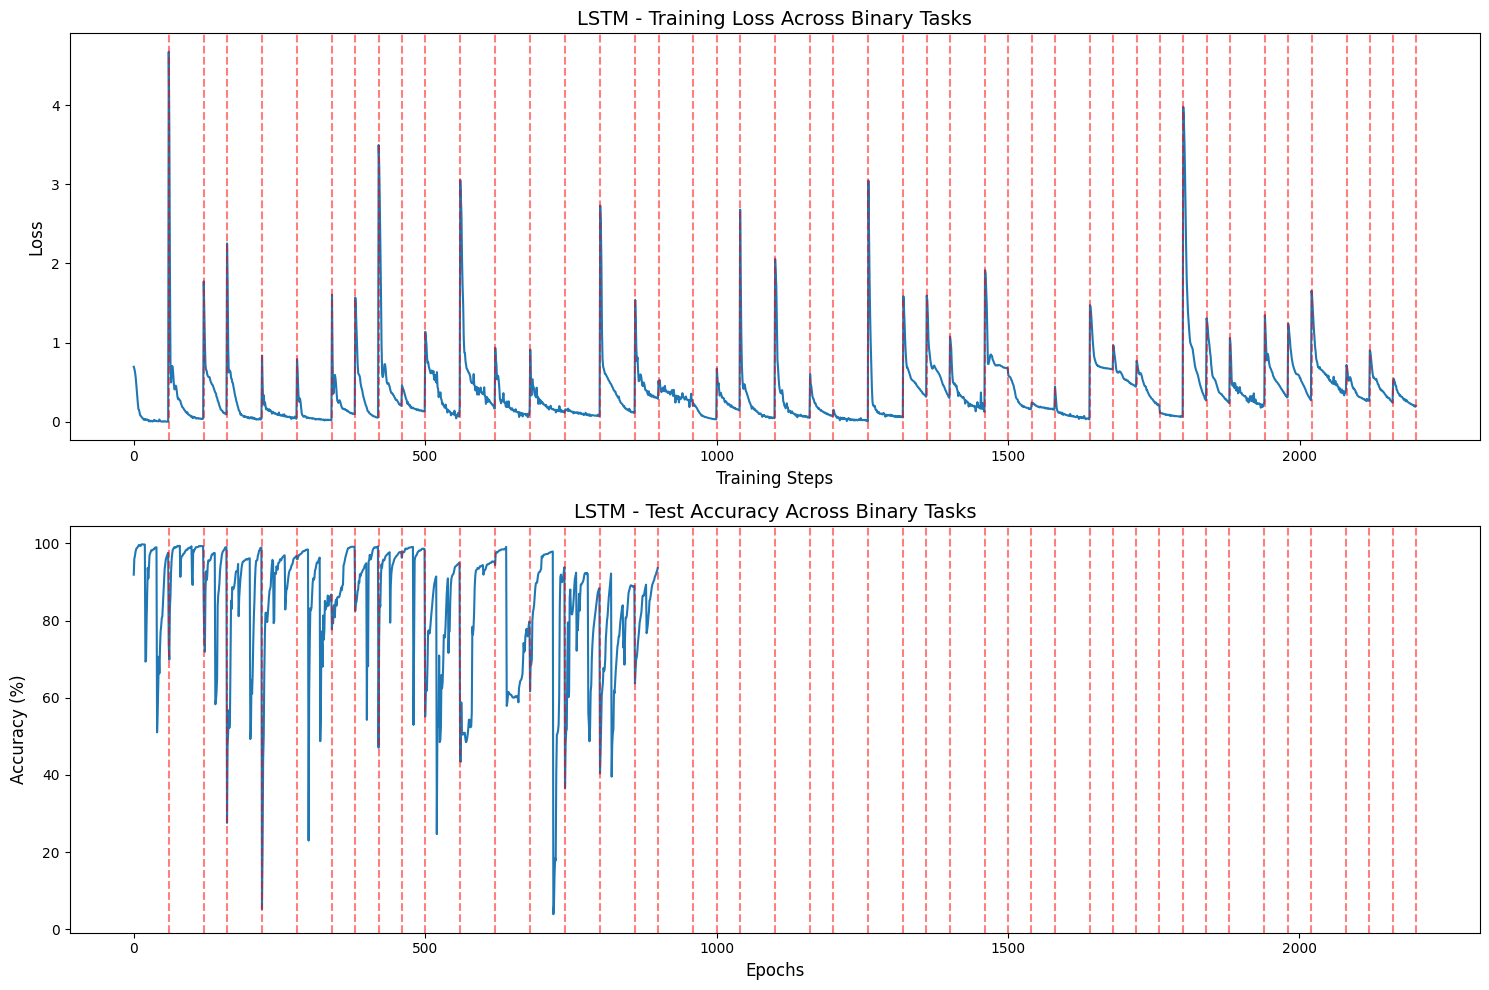

Loss figure saved to: output/mnist_binary_lstm_loss.png


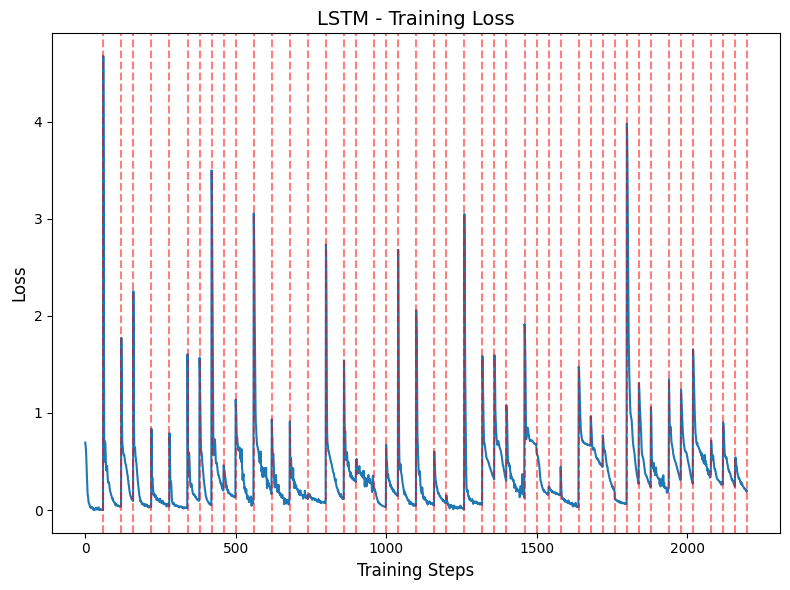

Accuracy figure saved to: output/mnist_binary_lstm_accuracy.png


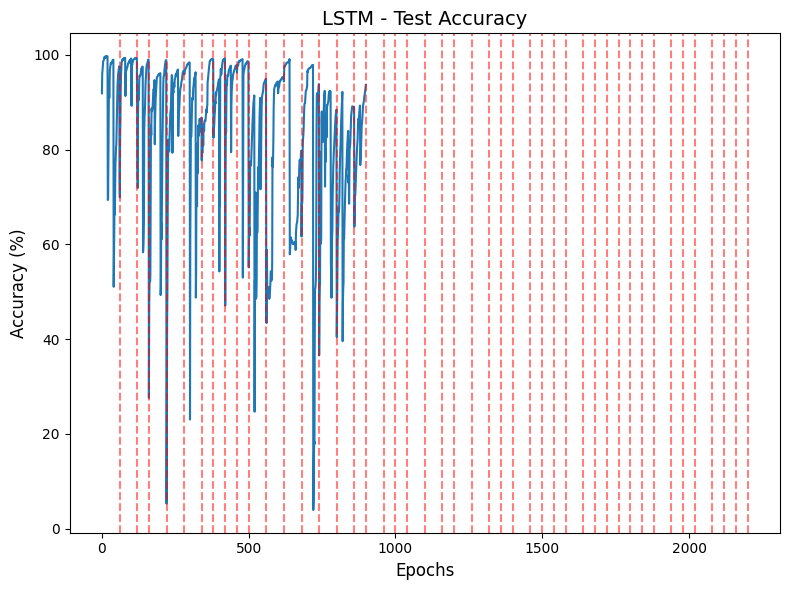

In [24]:
import os

# Ensure 'output' directory exists
output_dir = 'output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory '{output_dir}' was created.")

for model_name, train_log in train_logs.items():
    all_train_losses = train_log['all_train_losses']
    all_test_accuracies = train_log['all_test_accuracies']
    task_boundaries = train_log['task_boundaries']

    # 1. Combined Plot: Training Loss and Test Accuracy
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Training loss
    ax1.plot(all_train_losses)
    ax1.set_title(f'{model_name.upper()} - Training Loss Across Binary Tasks', fontsize=14)
    ax1.set_xlabel('Training Steps', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    for boundary in task_boundaries:
        ax1.axvline(x=boundary, color='red', linestyle='--', alpha=0.5)

    # Test accuracy
    ax2.plot(all_test_accuracies)
    ax2.set_title(f'{model_name.upper()} - Test Accuracy Across Binary Tasks', fontsize=14)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    for boundary in task_boundaries:
        ax2.axvline(x=boundary, color='red', linestyle='--', alpha=0.5)

    plt.tight_layout()
    combined_path = f"{output_dir}/mnist_binary_{model_name}_combined.png"
    plt.savefig(combined_path)
    print(f"Combined figure saved to: {combined_path}")
    plt.show()

    # 2. Separate Plot: Training Loss
    plt.figure(figsize=(8, 6))
    plt.plot(all_train_losses)
    plt.title(f'{model_name.upper()} - Training Loss', fontsize=14)
    plt.xlabel('Training Steps', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    for boundary in task_boundaries:
        plt.axvline(x=boundary, color='red', linestyle='--', alpha=0.5)
    plt.tight_layout()
    loss_path = f"{output_dir}/mnist_binary_{model_name}_loss.png"
    plt.savefig(loss_path)
    print(f"Loss figure saved to: {loss_path}")
    plt.show()

    # 3. Separate Plot: Test Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(all_test_accuracies)
    plt.title(f'{model_name.upper()} - Test Accuracy', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    for boundary in task_boundaries:
        plt.axvline(x=boundary, color='red', linestyle='--', alpha=0.5)
    plt.tight_layout()
    accuracy_path = f"{output_dir}/mnist_binary_{model_name}_accuracy.png"
    plt.savefig(accuracy_path)
    print(f"Accuracy figure saved to: {accuracy_path}")
    plt.show()
